In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/images_toits_output

cp: missing destination file operand after '/content/drive/MyDrive/images_toits_output'
Try 'cp --help' for more information.


In [3]:
# Import de librairies
import os, datetime
import warnings
warnings.filterwarnings("ignore")
import PIL
import PIL.Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.data import experimental
from tensorflow.keras.utils import plot_model, model_to_dot
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# !pip install -U keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.3 MB/s eta 0:00:00


In [4]:

# GPU utilisé dans l'instance colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb 10 08:51:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    29W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:

# Verifie l'accessibilité du GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import des données

In [6]:
# Les 4 classes correspondant aux toitures
class_list = ["BETON", 
              "TUILES", 
              "ARDOISES", 
              "ZINC ALUMINIUM"]

In [7]:

# Nombre de classes
num_class = len(class_list)

In [1]:
data_dir = '/content/drive/My Drive/PSB/images_toits/output'

In [8]:
# Paramètre d'imports des images par Keras
img_height = 224
img_width = 224
channels = 3
batch_size = 32
array_size= img_width * img_height * channels

224*224 est l'imput recommandé de VGG16:

https://keras.io/api/applications/vgg/

#**Training "from scratch" (sans transfert learning)**
##**Split training et validation**
Le split entre le set de training et de la validation est effectué avec les ImageDataGenerator qui permettent de charger les images par batch et ne saturent pas la RAM/VRAM.

Fixer la random seed des ImageDataGenerator permet d'obternir les mêmes sets (sans overlapping) d'un ImageDataGenerator à un autre, afin de conserver les mêmes sets pour chaque entrainement.


* training set: 1540 images, 80% du dataset
* validation set: 379 image, 20% du dataset

## VGG16
Je choisi de commencer mes expérimentations en recérant "from scratch" une architecture éprouvée, VGG16, avec initiation random des poids.

##VGG16 standard

In [ ]:
# import et resize des images
datagen = ImageDataGenerator(validation_split=0.2
                             )

In [ ]:
train_generator = datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )

Found 7619 images belonging to 4 classes.


In [ ]:
val_generator = datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 1903 images belonging to 4 classes.


In [ ]:
# Construction du modèle
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=num_class, activation="softmax"))

In [ ]:

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
     


In [ ]:

%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
239/239 [==============================] - ETA: 0s - loss: 1354.7998 - accuracy: 0.2775
Epoch 1: val_accuracy improved from -inf to 0.30793, saving model to 


239/239 [==============================] - 187s 776ms/step - loss: 1354.7998 - accuracy: 0.2775 - val_loss: 1.3786 - val_accuracy: 0.3079
Epoch 2/50
239/239 [==============================] - ETA: 0s - loss: 1.3808 - accuracy: 0.3078
Epoch 2: val_accuracy did not improve from 0.30793
239/239 [==============================] - 182s 761ms/step - loss: 1.3808 - accuracy: 0.3078 - val_loss: 1.3761 - val_accuracy: 0.3079
Epoch 3/50
239/239 [==============================] - ETA: 0s - loss: 1.3791 - accuracy: 0.3078
Epoch 3: val_accuracy did not improve from 0.30793
239/239 [==============================] - 180s 751ms/step - loss: 1.3791 - accuracy: 0.3078 - val_loss: 1.3760 - val_accuracy: 0.3079
Epoch 4/50
239/239 [==============================] - ETA: 0s - loss: 1.3794 - accuracy: 0.3078
Epoch 4: val_accuracy did not improve from 0.30793
239/239 [==============================] - 177s 740ms/step - loss: 1.3794 - accuracy: 0.3078 - val_loss: 1.3758 - val_accuracy: 0.3079
Epoch 5/50
239/2

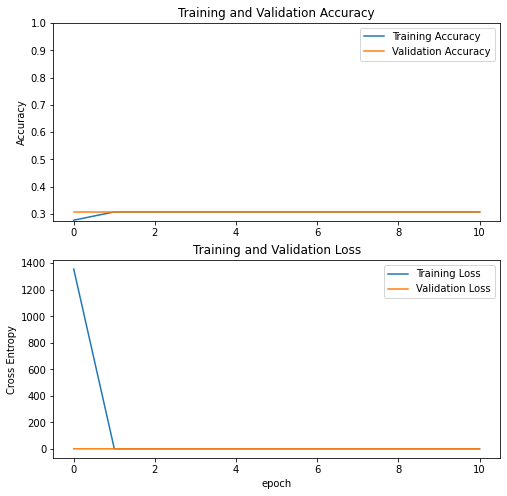

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#ResNet50

In [ ]:

# import des images, rezise et data augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  rotation_range=90,
                                  zoom_range=[0.5,1.5],
                                  brightness_range=[0.4,1.8],
                                  preprocessing_function=tf.keras.applications.resnet50.preprocess_input
                                  )

In [ ]:

val_datagen = ImageDataGenerator(validation_split=0.2,
                                 preprocessing_function=tf.keras.applications.resnet50.preprocess_input
                                )

In [ ]:

train_generator = train_datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )

Found 7619 images belonging to 4 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          #batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 1903 images belonging to 4 classes.


In [ ]:
# Construction du modèle
model = Sequential()

model.add(tf.keras.applications.ResNet50(include_top=False, input_shape=(img_width,img_height,3), pooling='avg', weights=None))
model.add(Flatten())
model.add(Dense(num_class, activation='softmax'))

In [ ]:

# Construction du modèle
model = Sequential()

model.add(tf.keras.applications.ResNet50(include_top=False, input_shape=(img_width,img_height,3), pooling='avg', weights=None))
model.add(Flatten())
model.add(Dense(num_class, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23,595,908
Trainable params: 23,542,788
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=5, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
239/239 [==============================] - ETA: 0s - loss: 1.8705 - accuracy: 0.2502
Epoch 1: val_accuracy improved from -inf to 0.26695, saving model to 


239/239 [==============================] - 294s 1s/step - loss: 1.8705 - accuracy: 0.2502 - val_loss: 45.2378 - val_accuracy: 0.2669
Epoch 2/50
239/239 [==============================] - ETA: 0s - loss: 1.6084 - accuracy: 0.2506
Epoch 2: val_accuracy did not improve from 0.26695
239/239 [==============================] - 258s 1s/step - loss: 1.6084 - accuracy: 0.2506 - val_loss: 49.2193 - val_accuracy: 0.2344
Epoch 3/50
239/239 [==============================] - ETA: 0s - loss: 1.5245 - accuracy: 0.2849
Epoch 3: val_accuracy did not improve from 0.26695
239/239 [==============================] - 257s 1s/step - loss: 1.5245 - accuracy: 0.2849 - val_loss: 21.4666 - val_accuracy: 0.2486
Epoch 4/50
239/239 [==============================] - ETA: 0s - loss: 1.4307 - accuracy: 0.2813
Epoch 4: val_accuracy did not improve from 0.26695
239/239 [==============================] - 260s 1s/step - loss: 1.4307 - accuracy: 0.2813 - val_loss: 1.4481 - val_accuracy: 0.2596
Epoch 5/50
239/239 [========

239/239 [==============================] - 284s 1s/step - loss: 1.4719 - accuracy: 0.2685 - val_loss: 3.9598 - val_accuracy: 0.2853
Epoch 6/50
239/239 [==============================] - ETA: 0s - loss: 1.5598 - accuracy: 0.2700
Epoch 6: val_accuracy did not improve from 0.28534
239/239 [==============================] - 264s 1s/step - loss: 1.5598 - accuracy: 0.2700 - val_loss: 1.4451 - val_accuracy: 0.2601
Epoch 7/50
239/239 [==============================] - ETA: 0s - loss: 1.4764 - accuracy: 0.2960
Epoch 7: val_accuracy improved from 0.28534 to 0.29585, saving model to 


239/239 [==============================] - 280s 1s/step - loss: 1.4764 - accuracy: 0.2960 - val_loss: 1.3938 - val_accuracy: 0.2958
Epoch 8/50
239/239 [==============================] - ETA: 0s - loss: 1.5408 - accuracy: 0.2353
Epoch 8: val_accuracy improved from 0.29585 to 0.29953, saving model to 


239/239 [==============================] - 280s 1s/step - loss: 1.5408 - accuracy: 0.2353 - val_loss: 3.9657 - val_accuracy: 0.2995
Epoch 9/50
239/239 [==============================] - ETA: 0s - loss: 1.4290 - accuracy: 0.2964
Epoch 9: val_accuracy improved from 0.29953 to 0.30793, saving model to 


239/239 [==============================] - 282s 1s/step - loss: 1.4290 - accuracy: 0.2964 - val_loss: 1.4014 - val_accuracy: 0.3079
Epoch 10/50
239/239 [==============================] - ETA: 0s - loss: 1.4440 - accuracy: 0.2786
Epoch 10: val_accuracy improved from 0.30793 to 0.31424, saving model to 


239/239 [==============================] - 277s 1s/step - loss: 1.4440 - accuracy: 0.2786 - val_loss: 1.4079 - val_accuracy: 0.3142
Epoch 11/50
239/239 [==============================] - ETA: 0s - loss: 1.5740 - accuracy: 0.2949
Epoch 11: val_accuracy did not improve from 0.31424
239/239 [==============================] - 256s 1s/step - loss: 1.5740 - accuracy: 0.2949 - val_loss: 1.4737 - val_accuracy: 0.2317
Epoch 12/50
239/239 [==============================] - ETA: 0s - loss: 1.4282 - accuracy: 0.3256
Epoch 12: val_accuracy did not improve from 0.31424
239/239 [==============================] - 259s 1s/step - loss: 1.4282 - accuracy: 0.3256 - val_loss: 1.3794 - val_accuracy: 0.2596
Epoch 13/50
239/239 [==============================] - ETA: 0s - loss: 1.4778 - accuracy: 0.2658
Epoch 13: val_accuracy did not improve from 0.31424
239/239 [==============================] - 256s 1s/step - loss: 1.4778 - accuracy: 0.2658 - val_loss: 1.4276 - val_accuracy: 0.2864
Epoch 14/50
239/239 [====

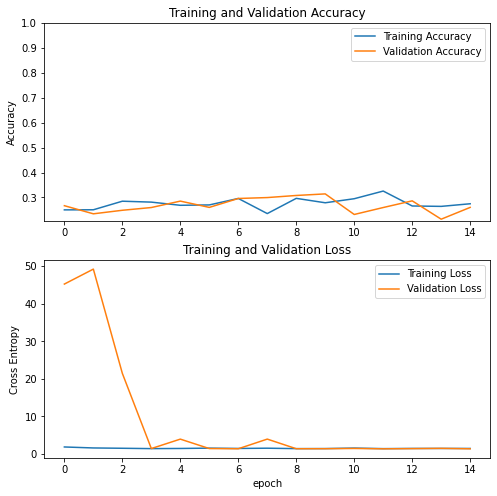

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#**avec Image Augmentation**

On fait de la data augmentation pour améliorer les résultats.
Rotation / flip bonne idée (vertical/horizontal) aller voir la doc de Keras
Brightness (car pas même ensoleillement à la base, dans des petites proportions 0,7 - 1,3)
Zoom que à 10% pas à 50%
Width_shif


In [ ]:

def visualize_augmentation():
  
  train_generator = datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=1,
                                              class_mode="categorical",
                                              subset="training",
                                              seed=123
                                              )
  
  batch=next(train_generator)

  print(batch[0].shape) # batch[0] is the images, batch[1] are the labels
  img=batch[0][0]   # this is the first image  batch[0][1] would be the next image
  print(img.shape)
  plt.imshow(img)   # shows the first image
  

In [ ]:
datagen = ImageDataGenerator(zoom_range=[0.1,1.5], rescale = 1./255)

Found 9522 images belonging to 4 classes.
(1, 224, 224, 3)
(224, 224, 3)


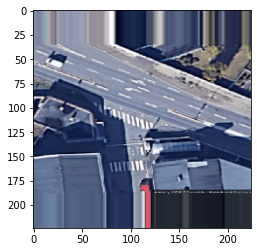

In [ ]:
visualize_augmentation()


In [ ]:
datagen = ImageDataGenerator(rotation_range=90, rescale = 1./255)


Found 9522 images belonging to 4 classes.
(1, 224, 224, 3)
(224, 224, 3)


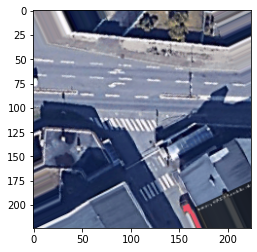

In [ ]:
visualize_augmentation()


In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, rescale = 1./255)


Found 9522 images belonging to 4 classes.
(1, 224, 224, 3)
(224, 224, 3)


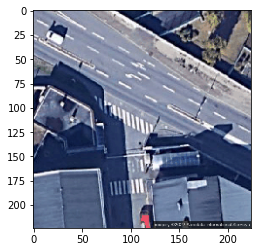

In [ ]:
visualize_augmentation()


In [ ]:
datagen = ImageDataGenerator(vertical_flip=True, rescale = 1./255)

Found 9522 images belonging to 4 classes.
(1, 224, 224, 3)
(224, 224, 3)


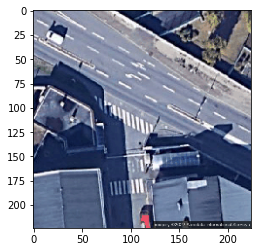

In [ ]:
visualize_augmentation()


In [ ]:
datagen = ImageDataGenerator(brightness_range=[0.4,1.8], rescale = 1./255)


Found 9522 images belonging to 4 classes.
(1, 224, 224, 3)
(224, 224, 3)


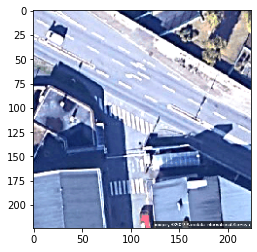

In [ ]:
visualize_augmentation()


##Training avec image augmentation

In [ ]:

# import des images, rezise et data augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  horizontal_flip=True,
                                   vertical_flip = True,
                                  rotation_range=90,
                                  zoom_range=0.1,
                                  brightness_range=[0.4,1.8]
                                  )

In [ ]:

val_datagen = ImageDataGenerator(validation_split=0.2
                                )

In [ ]:

train_generator = train_datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )

Found 7619 images belonging to 4 classes.


In [ ]:
val_generator = val_datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          #batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 1903 images belonging to 4 classes.


In [ ]:
# Construction du modèle
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=num_class, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [ ]:
%%time
# training
checkpoint = ModelCheckpoint("", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=5, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
239/239 [==============================] - ETA: 0s - loss: 377.8663 - accuracy: 0.2864 
Epoch 1: val_accuracy improved from -inf to 0.30793, saving model to 


239/239 [==============================] - 6387s 27s/step - loss: 377.8663 - accuracy: 0.2864 - val_loss: 1.3820 - val_accuracy: 0.3079
Epoch 2/50
239/239 [==============================] - ETA: 0s - loss: 1.3812 - accuracy: 0.3078
Epoch 2: val_accuracy did not improve from 0.30793
239/239 [==============================] - 258s 1s/step - loss: 1.3812 - accuracy: 0.3078 - val_loss: 1.3764 - val_accuracy: 0.3079
Epoch 3/50
239/239 [==============================] - ETA: 0s - loss: 1.3819 - accuracy: 0.3078
Epoch 3: val_accuracy did not improve from 0.30793
239/239 [==============================] - 253s 1s/step - loss: 1.3819 - accuracy: 0.3078 - val_loss: 1.3754 - val_accuracy: 0.3079
Epoch 4/50
239/239 [==============================] - ETA: 0s - loss: 1.3807 - accuracy: 0.3078
Epoch 4: val_accuracy did not improve from 0.30793
239/239 [==============================] - 247s 1s/step - loss: 1.3807 - accuracy: 0.3078 - val_loss: 1.3752 - val_accuracy: 0.3079
Epoch 5/50
239/239 [=======

In [ ]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##Transfer learning - ResNet50

In [9]:
# import des images, rezise et data augmentation
train_datagen = ImageDataGenerator(validation_split=0.2,
                                  horizontal_flip=True,
                                   vertical_flip = True,
                                  rotation_range=90,
                                  zoom_range=[0.1,1.5],
                                  brightness_range=[0.4,1.8],
                                  preprocessing_function=tf.keras.applications.resnet50.preprocess_input
                                  )

In [10]:

val_datagen = ImageDataGenerator(validation_split=0.2,
                                 preprocessing_function=tf.keras.applications.resnet50.preprocess_input
                                )

In [11]:

train_generator = train_datagen.flow_from_directory(data_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              classes=class_list,
                                              subset="training",
                                              seed=42,
                                              shuffle=False
                                              )

Found 7619 images belonging to 4 classes.


In [12]:
val_generator = val_datagen.flow_from_directory(data_dir,
                                          target_size=(img_height,img_width),
                                          #batch_size=batch_size,
                                          class_mode='categorical',
                                          classes=class_list,
                                          subset="validation",
                                          seed=42,
                                          shuffle=False
                                          )

Found 1903 images belonging to 4 classes.


###3 couches dense

In [13]:
# Construction du modèle
model = Sequential()

model.add(tf.keras.applications.ResNet50(include_top=False, input_shape=(img_width,img_height,3), pooling='avg', weights='imagenet'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(num_class, activation='softmax'))

model.layers[0].trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [14]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 26,212,740
Trainable params: 2,625,028
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:

# Définition de l'optimizer et du learning rate
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
     

In [16]:
%%time
# training
checkpoint = ModelCheckpoint("/content/drive/My Drive/PSB/images_toits", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

hist = model.fit(train_generator, 
                 validation_data=val_generator, 
                 epochs=50, 
                 callbacks=[checkpoint,early])

Epoch 1/50
239/239 [==============================] - ETA: 0s - loss: 1.4730 - accuracy: 0.3355 
Epoch 1: val_accuracy improved from -inf to 0.47977, saving model to /content/drive/My Drive/PSB/images_toits


239/239 [==============================] - 3325s 14s/step - loss: 1.4730 - accuracy: 0.3355 - val_loss: 1.2094 - val_accuracy: 0.4798
Epoch 2/50
239/239 [==============================] - ETA: 0s - loss: 1.2664 - accuracy: 0.4318
Epoch 2: val_accuracy did not improve from 0.47977
239/239 [==============================] - 270s 1s/step - loss: 1.2664 - accuracy: 0.4318 - val_loss: 1.1983 - val_accuracy: 0.4771
Epoch 3/50
239/239 [==============================] - ETA: 0s - loss: 1.2427 - accuracy: 0.4350
Epoch 3: val_accuracy improved from 0.47977 to 0.51287, saving model to /content/drive/My Drive/PSB/images_toits


239/239 [==============================] - 289s 1s/step - loss: 1.2427 - accuracy: 0.4350 - val_loss: 1.1638 - val_accuracy: 0.5129
Epoch 4/50
239/239 [==============================] - ETA: 0s - loss: 1.1827 - accuracy: 0.4759
Epoch 4: val_accuracy improved from 0.51287 to 0.54283, saving model to /content/drive/My Drive/PSB/images_toits


239/239 [==============================] - 289s 1s/step - loss: 1.1827 - accuracy: 0.4759 - val_loss: 1.1180 - val_accuracy: 0.5428
Epoch 5/50
239/239 [==============================] - ETA: 0s - loss: 1.1759 - accuracy: 0.4890
Epoch 5: val_accuracy did not improve from 0.54283
239/239 [==============================] - 265s 1s/step - loss: 1.1759 - accuracy: 0.4890 - val_loss: 1.1391 - val_accuracy: 0.5181
Epoch 6/50
239/239 [==============================] - ETA: 0s - loss: 1.1463 - accuracy: 0.5005
Epoch 6: val_accuracy did not improve from 0.54283
239/239 [==============================] - 269s 1s/step - loss: 1.1463 - accuracy: 0.5005 - val_loss: 1.1357 - val_accuracy: 0.5334
Epoch 7/50
239/239 [==============================] - ETA: 0s - loss: 1.1441 - accuracy: 0.5041
Epoch 7: val_accuracy did not improve from 0.54283
239/239 [==============================] - 261s 1s/step - loss: 1.1441 - accuracy: 0.5041 - val_loss: 1.1293 - val_accuracy: 0.5328
Epoch 8/50
239/239 [===========

239/239 [==============================] - 282s 1s/step - loss: 1.1254 - accuracy: 0.5165 - val_loss: 1.1106 - val_accuracy: 0.5449
Epoch 11/50
239/239 [==============================] - ETA: 0s - loss: 1.1065 - accuracy: 0.5313
Epoch 11: val_accuracy did not improve from 0.54493
239/239 [==============================] - 257s 1s/step - loss: 1.1065 - accuracy: 0.5313 - val_loss: 1.1560 - val_accuracy: 0.5155
Epoch 12/50
239/239 [==============================] - ETA: 0s - loss: 1.1082 - accuracy: 0.5322
Epoch 12: val_accuracy did not improve from 0.54493
239/239 [==============================] - 258s 1s/step - loss: 1.1082 - accuracy: 0.5322 - val_loss: 1.0960 - val_accuracy: 0.5313
Epoch 13/50
239/239 [==============================] - ETA: 0s - loss: 1.0963 - accuracy: 0.5366
Epoch 13: val_accuracy improved from 0.54493 to 0.56227, saving model to /content/drive/My Drive/PSB/images_toits


239/239 [==============================] - 280s 1s/step - loss: 1.0963 - accuracy: 0.5366 - val_loss: 1.0938 - val_accuracy: 0.5623
Epoch 14/50
239/239 [==============================] - ETA: 0s - loss: 1.0955 - accuracy: 0.5385
Epoch 14: val_accuracy did not improve from 0.56227
239/239 [==============================] - 257s 1s/step - loss: 1.0955 - accuracy: 0.5385 - val_loss: 1.1016 - val_accuracy: 0.5581
Epoch 15/50
239/239 [==============================] - ETA: 0s - loss: 1.1029 - accuracy: 0.5316
Epoch 15: val_accuracy did not improve from 0.56227
239/239 [==============================] - 258s 1s/step - loss: 1.1029 - accuracy: 0.5316 - val_loss: 1.1284 - val_accuracy: 0.5297
Epoch 16/50
239/239 [==============================] - ETA: 0s - loss: 1.0869 - accuracy: 0.5331
Epoch 16: val_accuracy did not improve from 0.56227
239/239 [==============================] - 259s 1s/step - loss: 1.0869 - accuracy: 0.5331 - val_loss: 1.1113 - val_accuracy: 0.5560
Epoch 17/50
239/239 [====

239/239 [==============================] - 279s 1s/step - loss: 1.0818 - accuracy: 0.5446 - val_loss: 1.0871 - val_accuracy: 0.5665
Epoch 18/50
239/239 [==============================] - ETA: 0s - loss: 1.0931 - accuracy: 0.5342
Epoch 18: val_accuracy did not improve from 0.56647
239/239 [==============================] - 257s 1s/step - loss: 1.0931 - accuracy: 0.5342 - val_loss: 1.0677 - val_accuracy: 0.5628
Epoch 19/50
239/239 [==============================] - ETA: 0s - loss: 1.0795 - accuracy: 0.5506
Epoch 19: val_accuracy improved from 0.56647 to 0.57751, saving model to /content/drive/My Drive/PSB/images_toits


239/239 [==============================] - 280s 1s/step - loss: 1.0795 - accuracy: 0.5506 - val_loss: 1.0526 - val_accuracy: 0.5775
Epoch 20/50
239/239 [==============================] - ETA: 0s - loss: 1.0828 - accuracy: 0.5463
Epoch 20: val_accuracy did not improve from 0.57751
239/239 [==============================] - 257s 1s/step - loss: 1.0828 - accuracy: 0.5463 - val_loss: 1.0596 - val_accuracy: 0.5712
Epoch 21/50
239/239 [==============================] - ETA: 0s - loss: 1.0789 - accuracy: 0.5405
Epoch 21: val_accuracy did not improve from 0.57751
239/239 [==============================] - 255s 1s/step - loss: 1.0789 - accuracy: 0.5405 - val_loss: 1.0789 - val_accuracy: 0.5428
Epoch 22/50
239/239 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.5516
Epoch 22: val_accuracy did not improve from 0.57751
239/239 [==============================] - 257s 1s/step - loss: 1.0686 - accuracy: 0.5516 - val_loss: 1.0633 - val_accuracy: 0.5696
Epoch 23/50
239/239 [====

239/239 [==============================] - 278s 1s/step - loss: 1.0646 - accuracy: 0.5523 - val_loss: 1.0538 - val_accuracy: 0.5864
Epoch 26/50
239/239 [==============================] - ETA: 0s - loss: 1.0549 - accuracy: 0.5636
Epoch 26: val_accuracy did not improve from 0.58644
239/239 [==============================] - 257s 1s/step - loss: 1.0549 - accuracy: 0.5636 - val_loss: 1.1078 - val_accuracy: 0.5265
Epoch 27/50
239/239 [==============================] - ETA: 0s - loss: 1.0603 - accuracy: 0.5564
Epoch 27: val_accuracy did not improve from 0.58644
239/239 [==============================] - 256s 1s/step - loss: 1.0603 - accuracy: 0.5564 - val_loss: 1.0830 - val_accuracy: 0.5702
Epoch 28/50
239/239 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.5625
Epoch 28: val_accuracy did not improve from 0.58644
239/239 [==============================] - 257s 1s/step - loss: 1.0534 - accuracy: 0.5625 - val_loss: 1.0608 - val_accuracy: 0.5775
Epoch 29/50
239/239 [====

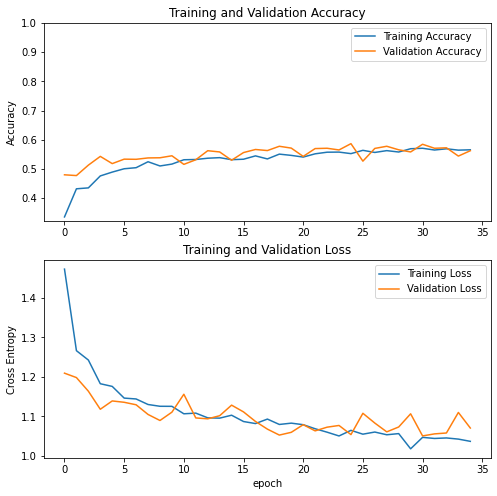

In [17]:
# Plots des accuracy et cross entropy pour les sets de training et de validation par epoch
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
# pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 15.5 MB/s eta 0:00:00


In [35]:
import shap
import numpy as np

In [21]:
# explain how the input to the 3rd layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [34]:
e = shap.GradientExplainer(
    (model.layers[3].input, model.layers[-1].output),
    map2layer(X, 3),
    local_smoothing=0 # std dev of smoothing noise
)

NameError: ignored